In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from copy import deepcopy
import pickle as pkl

from ex_cosmology import p
from matplotlib import gridspec
import matplotlib.patches as mpatches

# adaptive-wavelets modules
import awave
from awave.data.cosmology import get_dataloader, load_pretrained_model
from awave.data.cosmology import get_validation
from awave.utils.misc import tuple_to_tensor
from awave.trim import TrimModel
from umap import UMAP
from sklearn.decomposition import PCA

# evaluation
from eval_cosmology import load_results, rmse_bootstrap, extract_patches
from peak_counting import PeakCount

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dirs = [
    "db5_saliency_warmstart_seed=1_new"
]
dics, results, models = load_results(dirs)

In [3]:
# get dataloader and model
train_loader, val_loader = get_dataloader(p.data_path,
                                          img_size=p.img_size[2],
                                          split_train_test=True,
                                          batch_size=p.batch_size)

model = load_pretrained_model(model_name='resnet18', device=device, data_path=p.model_path)

# validation dataset
test_loader = get_validation(p.data_path,
                             img_size=p.img_size[2],
                             batch_size=p.batch_size)

# Optimal wavelet

In [4]:
# # DB5
wt_o = awave.DWT2d(wave='db5', mode='zero', J=4,
                               init_factor=1, noise_factor=0, const_factor=0)

# load optimal wavelet for prediction on heldout dataset
bds = np.linspace(0.015, 0.035, 5)
scores = pkl.load(open('results/scores_new.pkl', 'rb'))
row, col = np.unravel_index(np.argmin(scores, axis=None), scores.shape)
bd_opt = bds[row]
idx1, idx2 = list(dics[0]['wt'].keys())[col + 1]  ## NEED TO CHECK
# idx2 = 4
wt = dics[0]['wt'][(idx1, idx2)].to('cpu')

In [7]:
X1_batch = []
X2_batch = []
y_test = []
for x,y in test_loader:
    X1_batch.append(wt(x))
    X2_batch.append(wt_o(x))
    y_test.append(y)
    
X1 = tuple()
X2 = tuple()
for idx in range(5):
    a = [x[idx] for x in X1_batch]
    X1 += (torch.cat(a, dim=0),)
    b = [x[idx] for x in X2_batch]
    X2 += (torch.cat(b, dim=0),)
y_test = torch.cat([a[:,1] for a in y_test], dim=0)

# pca
pca = PCA(n_components=6)

# Raw data

In [19]:
# batch_size = 2000
# all_coefs = [x.detach().numpy().squeeze().reshape(batch_size, -1) for x in X1]
# shapes = [x.shape[1] for x in all_coefs]
# # all_coefs = [(x - x.min())/(x.max()-x.min()) for x in all_coefs]
# plt.figure(dpi=300, figsize=(8, 8))
# plt.imshow(np.hstack(all_coefs).transpose())
# # sns.clustermap(np.hstack(all_coefs).transpose()[:, :100])
# plt.yticks([0, *np.cumsum(shapes)], labels=['\nApproximation\ncoefs', '\nDetail\nLevel 1 coefs', '\nDetail\nLevel 2 coefs', '\nDetail\nLevel 3 coefs', '\nDetail\nLevel 4 coefs'])
# plt.xlabel('Each column represents a single time-series input')
# plt.show()

In [20]:
# batch_size = 2000
# all_coefs = [x.detach().numpy().squeeze().reshape(batch_size, -1) for x in X2]
# shapes = [x.shape[1] for x in all_coefs]
# # all_coefs = [(x - x.min())/(x.max()-x.min()) for x in all_coefs]
# plt.figure(dpi=300, figsize=(8, 8))
# plt.imshow(np.hstack(all_coefs).transpose()[:, :70])
# plt.yticks([0, *np.cumsum(shapes)], labels=['\nApproximation\ncoefs', '\nDetail\nLevel 1 coefs', '\nDetail\nLevel 2 coefs', '\nDetail\nLevel 3 coefs', '\nDetail\nLevel 4 coefs'])
# plt.xlabel('Each column represents a single time-series input')
# plt.show()

# PCA

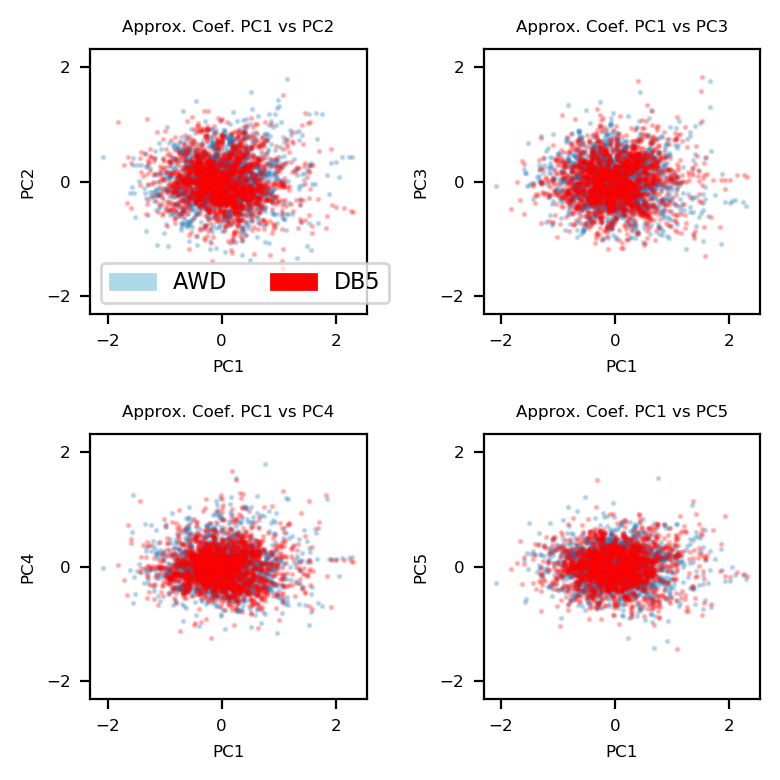

In [42]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['red', 'lightblue']
n = batch_size

# run pca
idx = 0
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding = pca.fit_transform(d)

# embedding1 vs embedding2
f_ax1 = fig.add_subplot(spec[0, 0])

h1 = plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2) #, cmap='Blues')
h2 = plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, c='red', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
blue_patch = mpatches.Patch(color='lightblue', label='AWD')
red_patch = mpatches.Patch(color='red', label='DB5')
plt.legend((h1, h2),
           ('AWD', 'DB5'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8,
           handles=(blue_patch, red_patch))
plt.title("Approx. Coef. PC1 vs PC2", fontsize=6)
plt.xticks([-2, 0, 2], fontsize=6)
plt.yticks([-2, 0, 2], fontsize=6)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC2', fontsize=6)

# embedding1 vs embedding2
f_ax2 = fig.add_subplot(spec[0, 1])

b1 = plt.scatter(embedding[:n, 0], embedding[:n, 2], marker=".", s=5, alpha=0.2) #, cmap='Blues')
b2 = plt.scatter(embedding[n:, 0], embedding[n:, 2], marker=".", s=5, c='red', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Approx. Coef. PC1 vs PC3", fontsize=6)
plt.xticks([-2, 0, 2], fontsize=6)
plt.yticks([-2, 0, 2], fontsize=6)
# plt.colorbar(b1)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC3', fontsize=6)

# embedding1 vs embedding2
f_ax3 = fig.add_subplot(spec[1, 0])

plt.scatter(embedding[:n, 0], embedding[:n, 3], marker=".", s=5, alpha=0.2) #, cmap='Blues')
plt.scatter(embedding[n:, 0], embedding[n:, 3], marker=".", s=5, c='red', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Approx. Coef. PC1 vs PC4", fontsize=6)
plt.xticks([-2, 0, 2], fontsize=6)
plt.yticks([-2, 0, 2], fontsize=6)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC4', fontsize=6)

# embedding1 vs embedding2
f_ax4 = fig.add_subplot(spec[1, 1])

r1 = plt.scatter(embedding[:n, 0], embedding[:n, 4], marker=".", s=5, alpha=0.2) #, cmap='Blues')
r2 = plt.scatter(embedding[n:, 0], embedding[n:, 4], marker=".", s=5, c='red', alpha=0.2) #y_test, cmap='Reds')  
plt.gca().set_aspect('equal', 'datalim')
plt.title("Approx. Coef. PC1 vs PC5", fontsize=6)
plt.xticks([-2, 0, 2], fontsize=6)
plt.yticks([-2, 0, 2], fontsize=6)
# plt.colorbar(r2)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC5', fontsize=6)
plt.tight_layout()
plt.show()

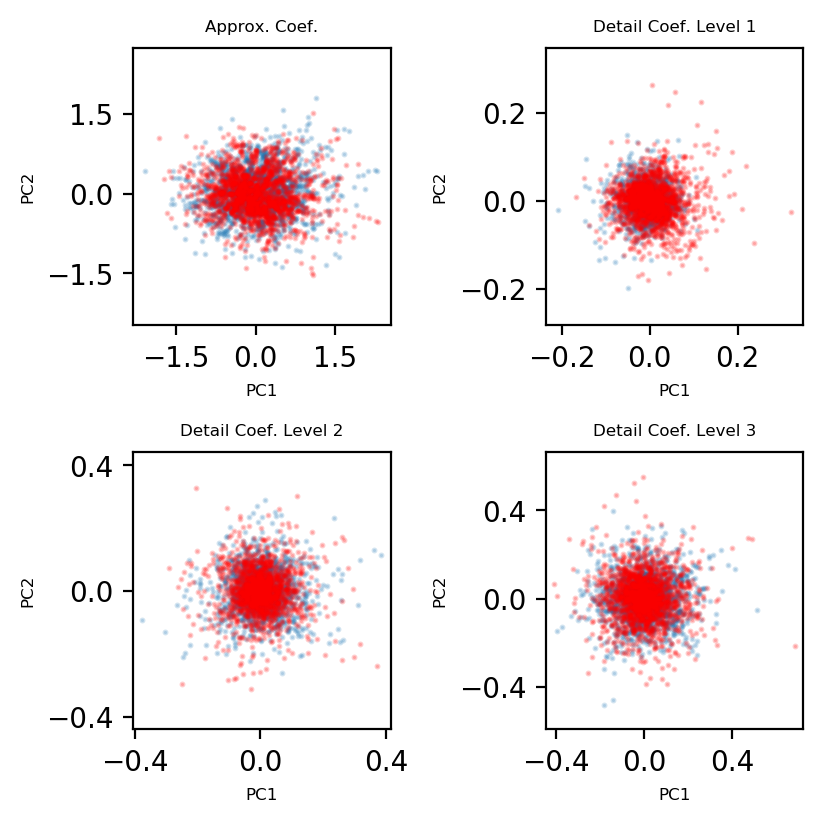

In [53]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
colors = ['red', 'lightblue']
n = batch_size

# embedding1 vs embedding2
f_ax1 = fig.add_subplot(spec[0, 0])

# run pca
idx = 0
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding = pca.fit_transform(d)

h1 = plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2)
h2 = plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, c='red', alpha=0.2)            
plt.gca().set_aspect('equal', 'datalim')
blue_patch = mpatches.Patch(color='lightblue', label='AWD')
red_patch = mpatches.Patch(color='red', label='DB5')
# plt.legend((h1, h2),
#            ('AWD', 'DB5'),
#            scatterpoints=1,
#            loc='lower left',
#            ncol=3,
#            fontsize=8,
#            handles=(blue_patch, red_patch))
plt.title("Approx. Coef.", fontsize=6)
plt.xticks([-1.5, 0, 1.5])
plt.yticks([-1.5, 0, 1.5])
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC2', fontsize=6)

# embedding1 vs embedding2
f_ax2 = fig.add_subplot(spec[0, 1])

# run pca
idx = 1
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding = pca.fit_transform(d)

b1 = plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2) #c=y_test, cmap='Blues')
b2 = plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, c='red', alpha=0.2) # c=y_test, cmap='Reds')   
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Detail Coef. Level 1", fontsize=6)
plt.xticks([-.2, 0, .2])
plt.yticks([-.2, 0, .2])
# plt.colorbarb1)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC2', fontsize=6)


# embedding1 vs embedding2
f_ax3 = fig.add_subplot(spec[1, 0])

# run pca
idx = 2
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding = pca.fit_transform(d)

plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2)
plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, c='red', alpha=0.2)  
plt.gca().set_aspect('equal', 'datalim')
# plt.legend()
plt.title("Detail Coef. Level 2", fontsize=6)
plt.xticks([-.4, 0, .4])
plt.yticks([-.4, 0, .4])
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC2', fontsize=6)


# embedding1 vs embedding2
f_ax4 = fig.add_subplot(spec[1, 1])

# run pca
idx = 3
d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
l1 = np.zeros(n)
l2 = np.ones(n)
d = np.concatenate((d1,d2), axis=0)
l = np.concatenate((l1,l2), axis=0)
embedding = pca.fit_transform(d)

r1 = plt.scatter(embedding[:n, 0], embedding[:n, 1], marker=".", s=5, alpha=0.2)
r2 = plt.scatter(embedding[n:, 0], embedding[n:, 1], marker=".", s=5, c='red', alpha=0.2)  
plt.gca().set_aspect('equal', 'datalim')
plt.title("Detail Coef. Level 3", fontsize=6)
plt.xticks([-.4, 0, .4])
plt.yticks([-.4, 0, .4])
# plt.colorbar(r2)
plt.xlabel('PC1', fontsize=6)
plt.ylabel('PC2', fontsize=6)

plt.show()

In [27]:
# run pca
pcas = []
pcas_db5 = []
for idx in range(4):
#     idx = 0
    d1 = X1[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
    d2 = X2[idx].detach().cpu().numpy().squeeze().reshape(batch_size, -1)
    l1 = np.zeros(n)
    pca = PCA(n_components=10)
    pca.fit_transform(d1)
    pcas.append(deepcopy(pca))
    
    pca = PCA(n_components=10)
    pca.fit_transform(d2)
    pcas_db5.append(deepcopy(pca))
    
#     embedding = pca.fit_transform(d)

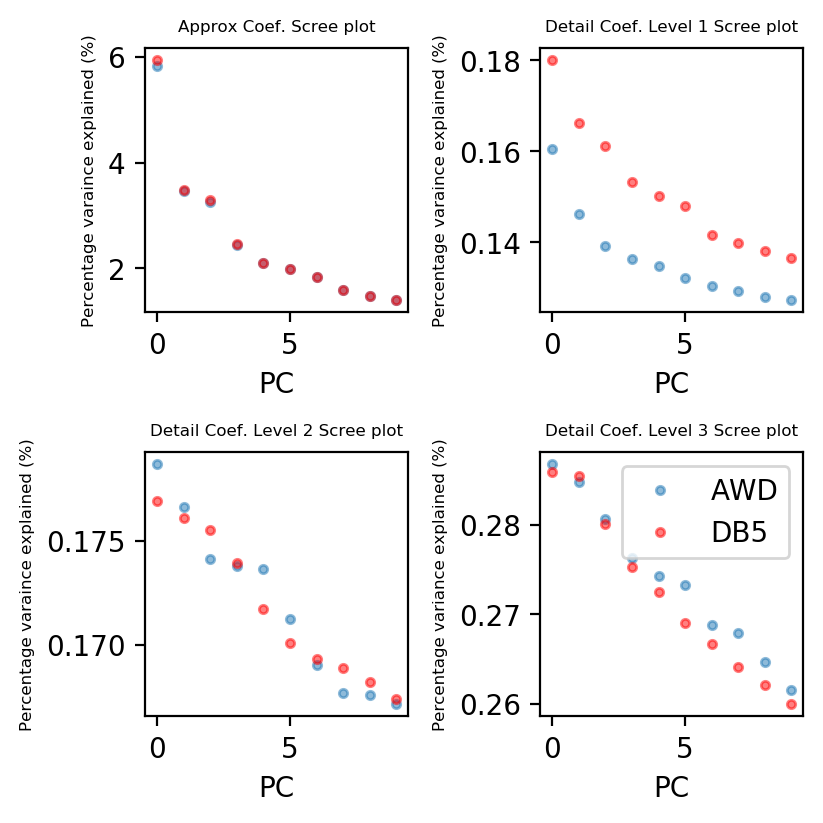

In [29]:
fig = plt.figure(constrained_layout=True, dpi=200, figsize=(4,4))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
n = batch_size

# plot 1
f_ax1 = fig.add_subplot(spec[0, 0])


plt.plot(pcas[0].explained_variance_ratio_*100, ".", alpha=.5)
plt.plot(pcas_db5[0].explained_variance_ratio_*100, ".", color="red", alpha=.5)
plt.xlabel("PC")
plt.ylabel("Percentage varaince explained (%)", fontsize=6)
plt.title("Approx Coef. Scree plot", fontsize=6)

# plot 2
f_ax2 = fig.add_subplot(spec[0, 1])
plt.plot(pcas[1].explained_variance_ratio_*100, ".", alpha=.5)
plt.plot(pcas_db5[1].explained_variance_ratio_*100, ".", color="red", alpha=.5)
plt.xlabel("PC")
plt.ylabel("Percentage varaince explained (%)", fontsize=6)
plt.title("Detail Coef. Level 1 Scree plot", fontsize=6)

# plot 3
f_ax3 = fig.add_subplot(spec[1, 0])
plt.plot(pcas[2].explained_variance_ratio_*100, ".", alpha=.5)
plt.plot(pcas_db5[2].explained_variance_ratio_*100, ".", color="red", alpha=.5)
plt.xlabel("PC")
plt.ylabel("Percentage varaince explained (%)", fontsize=6)
plt.title("Detail Coef. Level 2 Scree plot", fontsize=6)

# plot 4
f_ax4 = fig.add_subplot(spec[1, 1])
plt.plot(pcas[3].explained_variance_ratio_*100, ".", alpha=.5, label='AWD')
plt.plot(pcas_db5[3].explained_variance_ratio_*100, ".", color="red", alpha=.5, label='DB5')
plt.xlabel("PC")
plt.ylabel("Percentage variance explained (%)", fontsize=6)
plt.title("Detail Coef. Level 3 Scree plot", fontsize=6)
plt.legend()

plt.show()